In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torchmetrics
import matplotlib.pyplot as plt
from functools import partial
from transformers import AutoTokenizer

from scripts.utils import MultimodalRegressionModel, validate_regression, train
from scripts.dataset import MultimodalDataset, get_transforms, collate_fn

c:\Users\PM95Y\source\repos\multimodal_calorie_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. EDA

In [27]:
img_path = 'data/images'

In [31]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

In [32]:
images = ImageFolder(img_path, transform=transform)
dataloader = torch.utils.data.DataLoader(images, batch_size=4, shuffle=True)

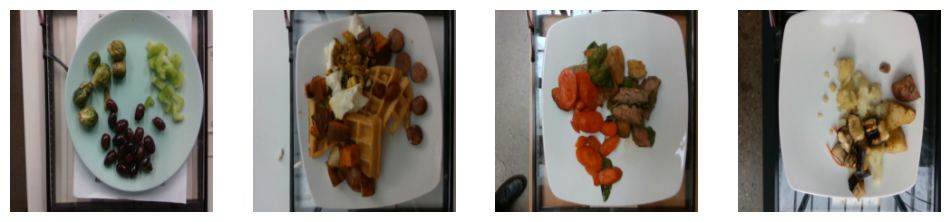

In [33]:
images, labels = next(iter(dataloader))

fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for i, (image, label) in enumerate(zip(images, labels)):
    img = image.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

## Выводы

- как вы будете решать задачу

    Буду решать задачу регрессии - картинку и список ингредиентов можно представить в виде одного эмбеддинга и по нему предсказать единое число (кол-во калорий).

- какие подходы к обогащению/аугментации данных примените и почему

    Датасет состоит из однотипных фотографий: тарелка (круглая или прямоугольная) с едой, вид сверху. Фотографии отличаются между собой яркостью освещения и положением еды на тарелке. При аугментации имеет смысл добавить в датасет легкую вариацию в контрастности/яркости/насыщенности (чтобы учесть разное освещение), а также повороты, чтобы модель могла учесть различные положения ингредиента на тарелке

- на какие метрики будете ориентироваться при обучении

    На метрику MAE (Mean Absolute Error).

# Этап 2. Обучение модели

In [2]:
class Config:
    # для воспроизводимости
    SEED = 42

    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    # Гиперпараметры
    BATCH_SIZE = 64
    TEXT_LR = 3e-4
    IMAGE_LR = 1e-3
    REGRESSOR_LR = 1e-2
    EPOCHS = 20
    DROPOUT = 0.0
    HIDDEN_DIM = 256

    # Пути
    DF_PATH = "data/dish.csv"
    SAVE_PATH = "best_model.pth"


device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = Config()

In [10]:
train(cfg, device) 

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

# Этап 3. Валидация качества

In [3]:
model = MultimodalRegressionModel(cfg)

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_NAME)

In [4]:
transforms = get_transforms(cfg)
train_dataset = MultimodalDataset(cfg, transforms)
train_loader = DataLoader(train_dataset,
                            batch_size=cfg.BATCH_SIZE,
                            shuffle=True,
                            collate_fn=partial(collate_fn,
                                                tokenizer=tokenizer))

mae_metric = torchmetrics.MeanAbsoluteError().to(device)

In [28]:
MAE = validate_regression(model, train_loader, device, mae_metric)

In [29]:
MAE

array(98.45396, dtype=float32)